###  Attention Map

In [2]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.resnet50 import preprocess_input

imagesize = 512
#tf.enable_eager_execution()

Using TensorFlow backend.


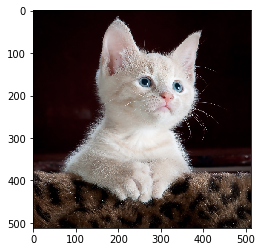

In [3]:
img = cv2.imread("cat.jpg")[:,:,::-1]
img = cv2.resize(img, (imagesize, imagesize))
ax = plt.imshow(img)

In [4]:
# (512, 512, 3) --> (1, 512, 512, 3)
def preprocess(img):
  # use the pre processing function of ResNet50 
  img = preprocess_input(img)
  
  #expand the dimension
  return np.expand_dims(img, 0)

In [5]:
def get_activations_at_1(modelx, i):
  #index the layer 
  out_layer = modelx.layers[i]
  
  #change the output of the model 
  modell = tf.keras.models.Model(inputs = modelx.inputs, outputs = out_layer.output)
  
  #return the activations
  return modell.predict(input_image)

def get_activations_at_2(modelx, i):
  #index the layer 
  out_layer = modelx.layers[i]
  
  #change the output of the model 
  modell = Model(inputs = modelx.inputs, outputs = out_layer.output)
  
  #return the activations
  return modell.predict([input_image, np.array([gender])])

In [6]:
def postprocess_activations(activations):

  #using the approach in https://arxiv.org/abs/1612.03928
  output = np.abs(activations)
  output = np.sum(output, axis = -1).squeeze()

  #resize and convert to image 
  output = cv2.resize(output, (imagesize, imagesize))
  output /= output.max()
  output *= 255
  return 255 - output.astype('uint8')

In [7]:
def apply_heatmap(weights):
  #generate heat maps 
  heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
  heatmap = cv2.addWeighted(heatmap, 0.6, img, 0.4, 0)
  return heatmap

In [8]:
def plot_heatmaps(typee, modelx, rng):
  level_maps = None
  
  #given a range of indices generate the heat maps 
  for i in rng:
    if typee==1:
        activations = get_activations_at_1(modelx, i)
    else:
        activations = get_activations_at_2(modelx, i)
    weights = postprocess_activations(activations)
    heatmap = apply_heatmap(weights)
    if level_maps is None:
      level_maps = heatmap
    else:
      level_maps = np.concatenate([level_maps, heatmap], axis = 1)
  plt.figure(figsize=(15, 15))
  plt.axis('off')
  ax = plt.imshow(level_maps)

In [9]:
input_image = preprocess(img)

# Resnet50

In [10]:
resnet_50 = tf.keras.applications.ResNet50(input_shape=(imagesize, imagesize, 3),include_top=False, weights='imagenet')
#resnet_50.summary()

In [11]:
len(resnet_50.layers),type(resnet_50),resnet_50.layers[170]

(175,
 tensorflow.python.keras.engine.training.Model,
 <tensorflow.python.keras.layers.core.Activation at 0x7f848c5eb630>)

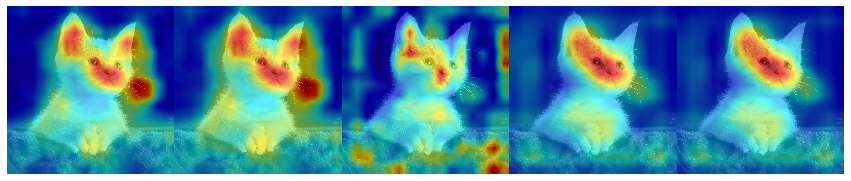

In [12]:
plot_heatmaps(1, resnet_50, range(165, 170))

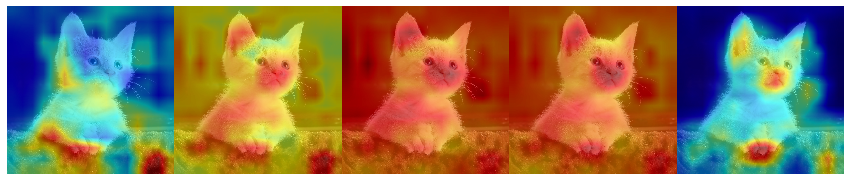

In [13]:
plot_heatmaps(1, resnet_50, range(170, 175))